In [44]:
import pandas as pd
import numpy as np
import pandahouse as ph
from read_db.CH import Getch
import matplotlib.pyplot as plt
import seaborn as sns
import pylab 
from scipy import stats

sns.set(font_scale=1.2, rc={'figure.figsize':(12,8)})

In [2]:
df = Getch("""
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220520.feed_actions 
WHERE toDate(time) between '2022-04-24' and '2022-04-30'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
""").df

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.  
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

##### Методы  
- t-тест 
- Пуассоновский бутстреп
- тест Манна-Уитни 
- t-тест на сглаженном ctr (α=5)
- t-тест и тест Манна-Уитни поверх бакетного преобразования

### t-test

In [6]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [44]:
exp_group2 = df[df['exp_group'] == 2]['ctr']

In [45]:
exp_group1 = df[df['exp_group'] == 1]['ctr']

In [46]:
exp_group1.mean(), exp_group2.mean()

(0.21560459841296287, 0.21441927347479375)

Средние по группам практически одинаковые

In [47]:
exp_group1.median(), exp_group2.median()

(0.203125, 0.1428571428571428)

Медиана тестовой группы сильно отклонилась от среднего

In [48]:
exp_group1.var(), exp_group2.var()

(0.007082824709479143, 0.02078786783139333)

In [6]:
len(exp_group2), len(exp_group1)

(9952, 10079)

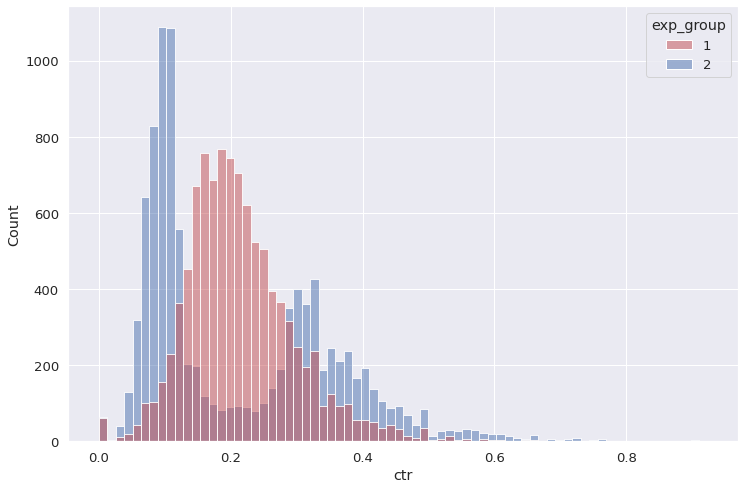

In [38]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

По гистограмме видно, что распределения не похожи
- распределение контрольной группы близко к нормальному с небольшой ассиметрией
- расперделение тестовой группы двумодально, на глаз можно сказать, что наши пользователи поделились на два сегмента

In [8]:
stats.ttest_ind(a=exp_group2, 
                b=exp_group1, 
                equal_var=False)

Ttest_indResult(statistic=-0.7094392041270485, pvalue=0.4780623130874935)

t-test показывает, что группы одинаковые, но в данных присутствует сильная ассиметрия

### u-test

In [11]:
stats.mannwhitneyu(exp_group1, exp_group2, alternative='two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Тест Манна - Уитни показывает, что группы разные

### Сглаженные CTR

Некоторые пользователи имеют мало просмотров и неизвестно, какой их истинный CTR  
Сглаживание увеличивает чувствительнось метрики

In [24]:
smothed_alpha = 5

smothed_alpha - это гипперпараметр

In [20]:
df['global_ctr'] = df.groupby('exp_group')['likes'].transform(sum)/df.groupby('exp_group')['views'].transform(sum)

In [35]:
df['smothed_ctr'] = (df['likes'] + smothed_alpha * df['global_ctr']) /(df['views'] + smothed_alpha)

In [36]:
df.head()

,exp_group,user_id,likes,views,ctr,global_ctr,smothed_ctr
0,1,109963,3,15,0.200000,0.208027,0.202007
1,1,26117,32,141,0.226950,0.208027,0.226302
2,1,138232,18,73,0.246575,0.208027,0.244104
3,1,26295,33,122,0.270492,0.208027,0.268033
4,1,18392,7,32,0.218750,0.208027,0.217301


In [40]:
smothed_ctr_exp_group2 = df[df['exp_group'] == 2]['smothed_ctr']
smothed_ctr_exp_group1 = df[df['exp_group'] == 1]['smothed_ctr']

In [55]:
smothed_ctr_exp_group1.mean(), smothed_ctr_exp_group2.mean()

(0.21402549608884142, 0.21073955503259234)

Можно заметить, что после сглаживания разница в средних увеличилась

In [54]:
smothed_ctr_exp_group1.median(), smothed_ctr_exp_group2.median()

(0.20348020325371466, 0.14787872931642587)

In [50]:
smothed_ctr_exp_group1.var(), smothed_ctr_exp_group2.var()

(0.0050934016819564045, 0.015566996076046192)

Дисперсия стала меньше

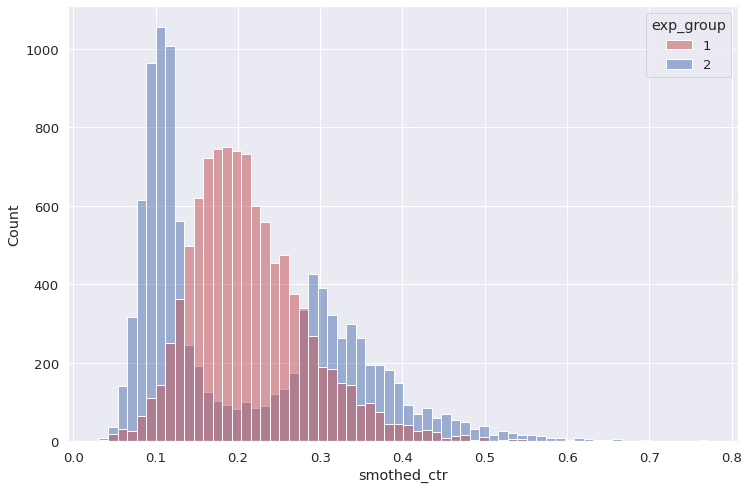

In [39]:
groups = sns.histplot(data = df, 
              x='smothed_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [53]:
stats.ttest_ind(a=smothed_ctr_exp_group1, 
                b=smothed_ctr_exp_group2, 
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

t-test на сглаженном ctr показал pvalue < 0.05  

### Пуассоновский бутстреп

Алгоритм 
- берем выборку из A  
- генерируем сколько раз user попал в псевдовыборку (получаем его вес weight)
- считаем по каждой псевдовыборке глобальный CTR   
      global_CTR =  sum(ckliks * weight) / sum(view * weight) если не попал вес 0, если несколько раз это будет учтено
- повторяем все то же самое, но уже для B
- считаем разницу между global_CTR_A - global_CTR_B

Предположение в том, что выборки из групп являются хорошим приближением к ГС

In [4]:
likes_A = df[df.exp_group == 1]['likes'].to_numpy()
likes_B = df[df.exp_group == 2]['likes'].to_numpy()
views_A = df[df.exp_group == 1]['views'].to_numpy()
views_B = df[df.exp_group == 2]['views'].to_numpy()

In [5]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1) )).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2) )).astype(np.int64)  
    
    global_CTR_A = (poisson_bootstraps1*likes1).sum(axis=1) / (poisson_bootstraps1*views1).sum(axis=1)
    global_CTR_B = (poisson_bootstraps2*likes2).sum(axis=1) / (poisson_bootstraps2*views2).sum(axis=1)
    
    return global_CTR_A, global_CTR_B

In [7]:
global_CTR_A, global_CTR_B = bootstrap(likes_A, views_A, likes_B, views_B, n_bootstrap=2000)

<AxesSubplot:ylabel='Count'>

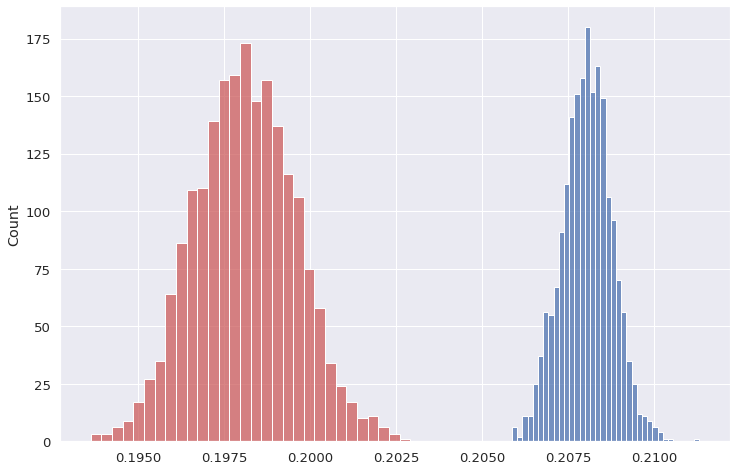

In [14]:
sns.histplot(global_CTR_A)
sns.histplot(global_CTR_B, color = 'indianred')

Распределения не пересекаются, если провести тест, то p-value будет 0

In [51]:
global_CTR_A.mean(), global_CTR_B.mean()

(0.20803452217521415, 0.19810996295237085)

In [57]:
np.median(global_CTR_A), np.median(global_CTR_B)

(0.20804166727848797, 0.19811464344288154)

In [58]:
global_CTR_A.var(), global_CTR_B.var()

(5.352383661904627e-07, 2.1169631576691326e-06)

<AxesSubplot:ylabel='Count'>

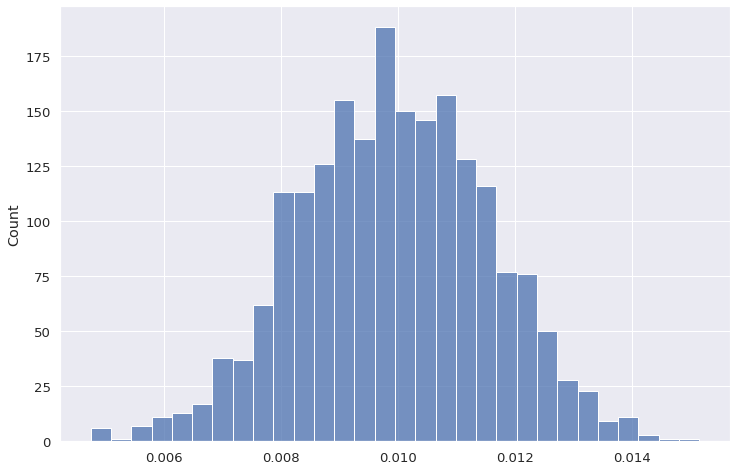

In [9]:
sns.histplot(global_CTR_A - global_CTR_B)

Гистограмма не пересекат 0 - это говорит о том, что одна группа строго больше другой
- справа от нуля, разница положительная и не нулевая
- группа B показала лучший результат, чем A

### Бакетное преобразование

Как считаются тесты поверх бакетного преобразования?  
- берем пользователей и случайно делим их на n - корзинок (бакетов)
- каждый пользователь в каждой группе попадет ровно в один бакет 
- пользователи по бакетам должны быть распределены +- равномерно

Каждый бакет - это 'метопользователь' и внутри него нам нужно агрегировать некий показатель, который будем сравнивать

In [63]:
df = Getch(""" SELECT 
                    exp_group, 
                    bucket,
                    sum(likes)/sum(views) as bucket_ctr
                FROM
                        (SELECT 
                            exp_group, 
                            xxHash64(user_id)%50 as bucket,
                            user_id,
                            sum(action = 'like') as likes,
                            sum(action = 'view') as views,
                            likes/views as ctr
                        FROM simulator_20220520.feed_actions 
                        WHERE toDate(time) between '2022-04-24' and '2022-04-30' and exp_group in (2,1)
                        GROUP BY exp_group, user_id)
                GROUP BY exp_group, bucket
            """).df

In [19]:
df.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


In [20]:
exp_group_bucket1 = df[df['exp_group'] == 1].bucket_ctr
exp_group_bucket2 = df[df['exp_group'] == 2].bucket_ctr

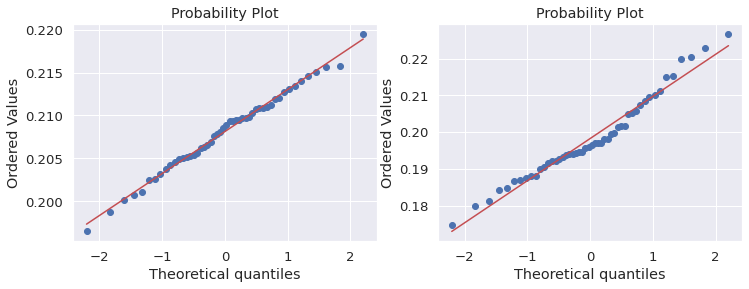

In [45]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
stats.probplot(exp_group_bucket1, dist="norm", plot=pylab)

plt.subplot(1,2,2)
stats.probplot(exp_group_bucket2, dist="norm", plot=pylab)
pylab.show()

Можно сказать, что после бакетного преобразования распределения напоминают нормальные

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

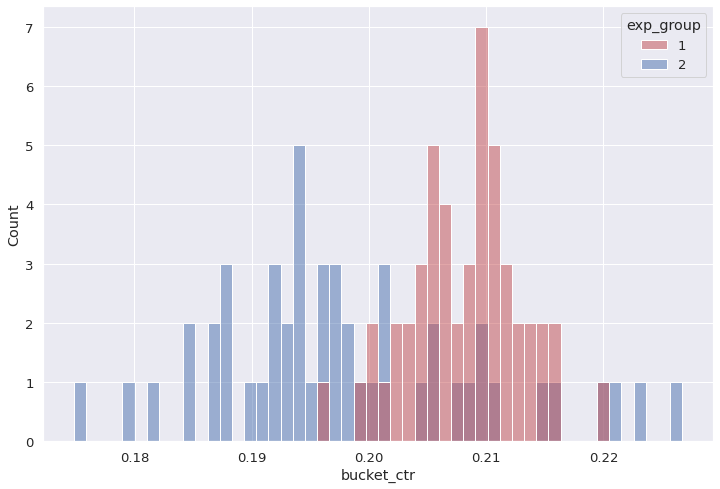

In [49]:
 sns.histplot(data=df,
              x='bucket_ctr',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              bins=50)

In [60]:
exp_group_bucket1.mean(), exp_group_bucket2.mean()

(0.20812170724336013, 0.19825944666552928)

Средние в группах стали сильнее отличаться, чем после сглаживания

In [61]:
exp_group_bucket1.median(), exp_group_bucket2.median()

(0.20870422646847037, 0.19620940011426305)

In [62]:
exp_group_bucket1.var(), exp_group_bucket2.var()

(2.291474230348919e-05, 0.0001284508960818103)

Медианы практически не отличаются от среднего 

In [37]:
stats.mannwhitneyu(exp_group_bucket1,
                   exp_group_bucket2,
                   alternative='two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [36]:
stats.ttest_ind(exp_group_bucket1, 
                exp_group_bucket2, 
                equal_var=False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

t-test показал меньший p-value, чем после сглаживания

#### Вывод

**t-test**
 - "Двугорбость" считается опасной для t-теста, нет оснований ему доверять
 
**u-test**
 - показал различия, также по распределению видно, что группы различаются

**t-test на сглаженных пользовательских CTR**
 - нет теоретических гарантий
 - повышает чувствительность теста
 - хорошо работает, когда асимметрия высока
 - дал статистически значимый результат, но не такой надежный, как u-test
 - средние стали немного различасться, дисперсия стала ниже
 
**Пуассоновский бутстреп**
 - позволил визуализировать различия
 - средние и медиана в группах стали одинаковыми, сильно понизили дисперсию

**Бакетное преобразование**
 - показал примерно такой же результат, как и бутстреп

По итогам тестов различия являются статистически значимыми, но не в пользу тестовой группы  

Раскатывать новый алгоритм рекомендаций на всех пользователей не стоит  
 
Возможно стоит доработать алгоритм, есть ощущение, что он хорошо работает на определенную аудиторию и совершенно не подходит другой